In [2]:
import pandas as pd 
import pymysql 
import csv 
import numpy as np 
from itertools import combinations 

import os 
import networkx as nx 

import dash
import dash_html_components as html
import dash_cytoscape as cyto 
import matplotlib.pyplot as plt 

In [3]:
conn = pymysql.connect(host = "localhost", 
              user = "root", 
              password = "1234", 
              db = "db_menu") 

In [8]:
def loadData(table): # get data from mysql database. 

    try: 
        conn = pymysql.connect(host = "localhost", 
                      user = "user", 
                      password = "Criatura12345@:", 
                      db = "db_menu") 
        query = "SELECT * FROM {}".format(table) 

        df = pd.read_sql(query, conn) 

        return df 
            
            
    except: 
        conn.close()         

In [9]:
dish = loadData("dish") 
dish.head() 

UnboundLocalError: local variable 'conn' referenced before assignment

In [4]:
menu_item= loadData("menu_item") 
menu_item.head() 

,id,menu_page_id,dish_id,price
0,1,1389,21,0.25
1,2,130,50,NaN
2,3,13915,50,NaN
3,4,5946,286,NaN
4,5,4857,286,NaN


In [5]:
menu = loadData("menu") 
menu.head() 

,id,name,event_date,event_id,sponsor_id,currency_id,venue_id
0,12463,None,1900-04-15,1,1,1,1
1,12465,None,1900-04-16,2,2,1,1
2,12466,None,1900-04-16,3,2,1,1
3,12470,None,1900-04-17,2,2,1,1
4,12475,None,1900-04-18,4,3,2,1


In [6]:
menu_page = loadData("menu_page") 
menu_page.head() 

,id,page_number,full_height,full_width,menu_id
0,130,1.0,3049,2004,12463
1,134,1.0,3411,2291,12465
2,136,1.0,3365,2305,12466
3,146,1.0,3427,2282,12470
4,168,1.0,3929,2494,12475


# Cálculos 

Doravante, serão feitos os cálculos para os nós, representados pelos pratos, e as arestas, indicativas da coexistência de refeições em um menu, dos grafos. Para isso, calcularemos, para cada par de pratos, em quantos menus eles aparecem juntos.  

Inicialmente, realizamos as necessárias junções nos conjuntos de dados para obter uma tabela razoável para construir um grafo. 

In [9]:
dish_page = pd.merge(dish, menu_item, left_on = "id", right_on = "dish_id")
dish_page.head() 

,id_x,name,description,id_y,menu_page_id,dish_id,price
0,21,English walnuts,None,1,1389,21,0.25
1,21,English walnuts,None,25,3531,21,0.10
2,21,English walnuts,None,43,4128,21,0.15
3,21,English walnuts,None,140,4377,21,NaN
4,21,English walnuts,None,151,4187,21,NaN


In [10]:
dish_page_menu = pd.merge(dish_page, menu_page, left_on = "menu_page_id", right_on = "id")
dish_page_menu = dish_page_menu[["name", "dish_id", "menu_page_id", "menu_id"]] 
dish_page_menu.head() 

,name,dish_id,menu_page_id,menu_id
0,English walnuts,21,1389,12882
1,English walnuts,21,3531,13619
2,"Omelet, plain",2001,3531,13619
3,English walnuts,21,4128,13810
4,English walnuts,21,4377,13900


In [11]:
dish_menu = pd.merge(dish_page_menu, menu, left_on = "menu_id", right_on = "id") 
dish_menu = dish_menu[["name_x", "dish_id", "menu_id", "event_date", "event_id", "sponsor_id"]] 
df = dish_menu.rename(columns = {"name_x": "name"}) 
df.head() 

,name,dish_id,menu_id,event_date,event_id,sponsor_id
0,English walnuts,21,12882,1900-04-09,22,56
1,English walnuts,21,13619,1901-04-26,22,159
2,"Omelet, plain",2001,13619,1901-04-26,22,159
3,Old Jamaica Rum,1353,13619,1901-04-26,22,159
4,SCOTCH WHISKEY,2818,13619,1901-04-26,22,159


In [ ]:
dish_names = df.name.unique() 

nodes = [] 
count = 0 
for combination in combinations(dish_names, 2): 
    print(count, end = "\r") 
    df_l = df[df["name"] == combination[0]] 
    df_r = df[df["name"] == combination[1]] 
    
    df_lr = pd.merge(df_l, df_r, on = "menu_id") 
    
    x = len(df_lr) 
    
    count = count + 1 
    nodes.append({
        "dish_l": combination[0], 
        "dish_r": combination[1], 
        "count": x 
    })        


Alternativamente, podemos fazer consultas em SQL. 

In [14]:
conn = pymysql.connect(host = "localhost", 
              user = "user", 
              password = "Criatura12345@:", 
              db = "db_menu") 
cur = conn.cursor() 

In [15]:
def get_df(year = None): 
    query_a = """ 
    SELECT dm.dish_id, dm.name, dm.menu_id, menu.event_date, menu.venue_id,   
           dm.menu_page_id FROM menu 
        JOIN (SELECT dish_id, name, menu_page_id, id, menu_id FROM menu_page 
                JOIN (SELECT dish_id, name, menu_page_id FROM dish
                        JOIN menu_item 
                        ON dish.id = menu_item.dish_id) as ds
                ON menu_page.id = ds.menu_page_id) as dm
        ON menu.id = dm.menu_id""" 

    query_b = """SELECT x.dish_id AS dish_id_x, y.dish_id AS dish_id_y, 
                 x.name AS name_x, y.name AS name_y, x.event_date, 
                 x.venue_id, x.menu_page_id, 
                 x.menu_id AS menu_id_x, y.menu_id AS menu_id_y 
                 FROM ({query}) AS x 
                 INNER JOIN ({query}) AS y 
                 ON x.menu_id = y.menu_id 
                 AND x.dish_id < y.dish_id""".format(query = query_a) 

    # filter year 

    if year is not None: 
        query_year = """SELECT * FROM ({query}) as a
                         WHERE YEAR(a.event_date) = {year}""".format(query = query_b, 
                                                                    year = year) 
    else: 
        query_year = query_b 

    query_c = """SELECT a.name_x, a.name_y, COUNT(a.name_x) as count  
                    FROM ({query}) as a 
                    GROUP BY a.name_x, a.name_y 
                    ORDER BY count DESC""".format(query = query_year) 
    df = pd.read_sql(query_c, conn) 
    return df  

In [16]:
df["year"] = list(map(lambda x: int(x[:4]) if x is not None else x, df["event_date"].tolist())) 
years = df.year.unique()

In [17]:
def save_file(table, name = "table"): 
    try: 
        os.mkdir("./data_csv") 
    except: 
        directory = "./data_csv/" 
    
    csv = table.to_csv(index = False) 
    
    with open(directory + name + ".csv", "w") as file: 
        file.write(csv)     

In [18]:
save_file(get_df()) 

In [19]:
try: 
    for year in years: 
        nodes_year = get_df(year) 
        save_file(nodes_year, name = "nodes_year_" + str(year))     
except Exception as e: 
    print("nan") 

nan


# NetworkX

Para o que falta, vamos utilizar o Dash Cytoscape para construir a visualização. 

In [134]:
df = get_df() 
np.random.seed(11) 
names_dish = df.name_x.unique() 
sample = np.random.choice(len(names_dish), 125) 
names = names_dish[sample] 

In [135]:
df = df[df["name_x"].isin(names)] 

In [136]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 1 to 1754
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name_x  414 non-null    object
 1   name_y  414 non-null    object
 2   count   414 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 12.9+ KB


In [137]:
df.name_x.value_counts() 

Stuffed Tomato     45
Salad, Chicken     34
Maryland Club      24
Stewed Rhubarb     22
Chateau Lafitte    18
                   ..
Club Saucisses      1
Boonekamp, A E      1
Fried bluefish      1
Stewed Squash       1
Kirschenkuchen      1
Name: name_x, Length: 101, dtype: int64

In [138]:
G = nx.Graph() 

## Add nodes

In [139]:
for name in names: 
    G.add_node(name, 
              color = "lightblue") 

In [140]:
for index in range(len(df.index)): 
    G.add_edge(
        df["name_x"].tolist()[index], 
        df["name_y"].tolist()[index], 
        frequency = df["count"].tolist()[index] 
    )

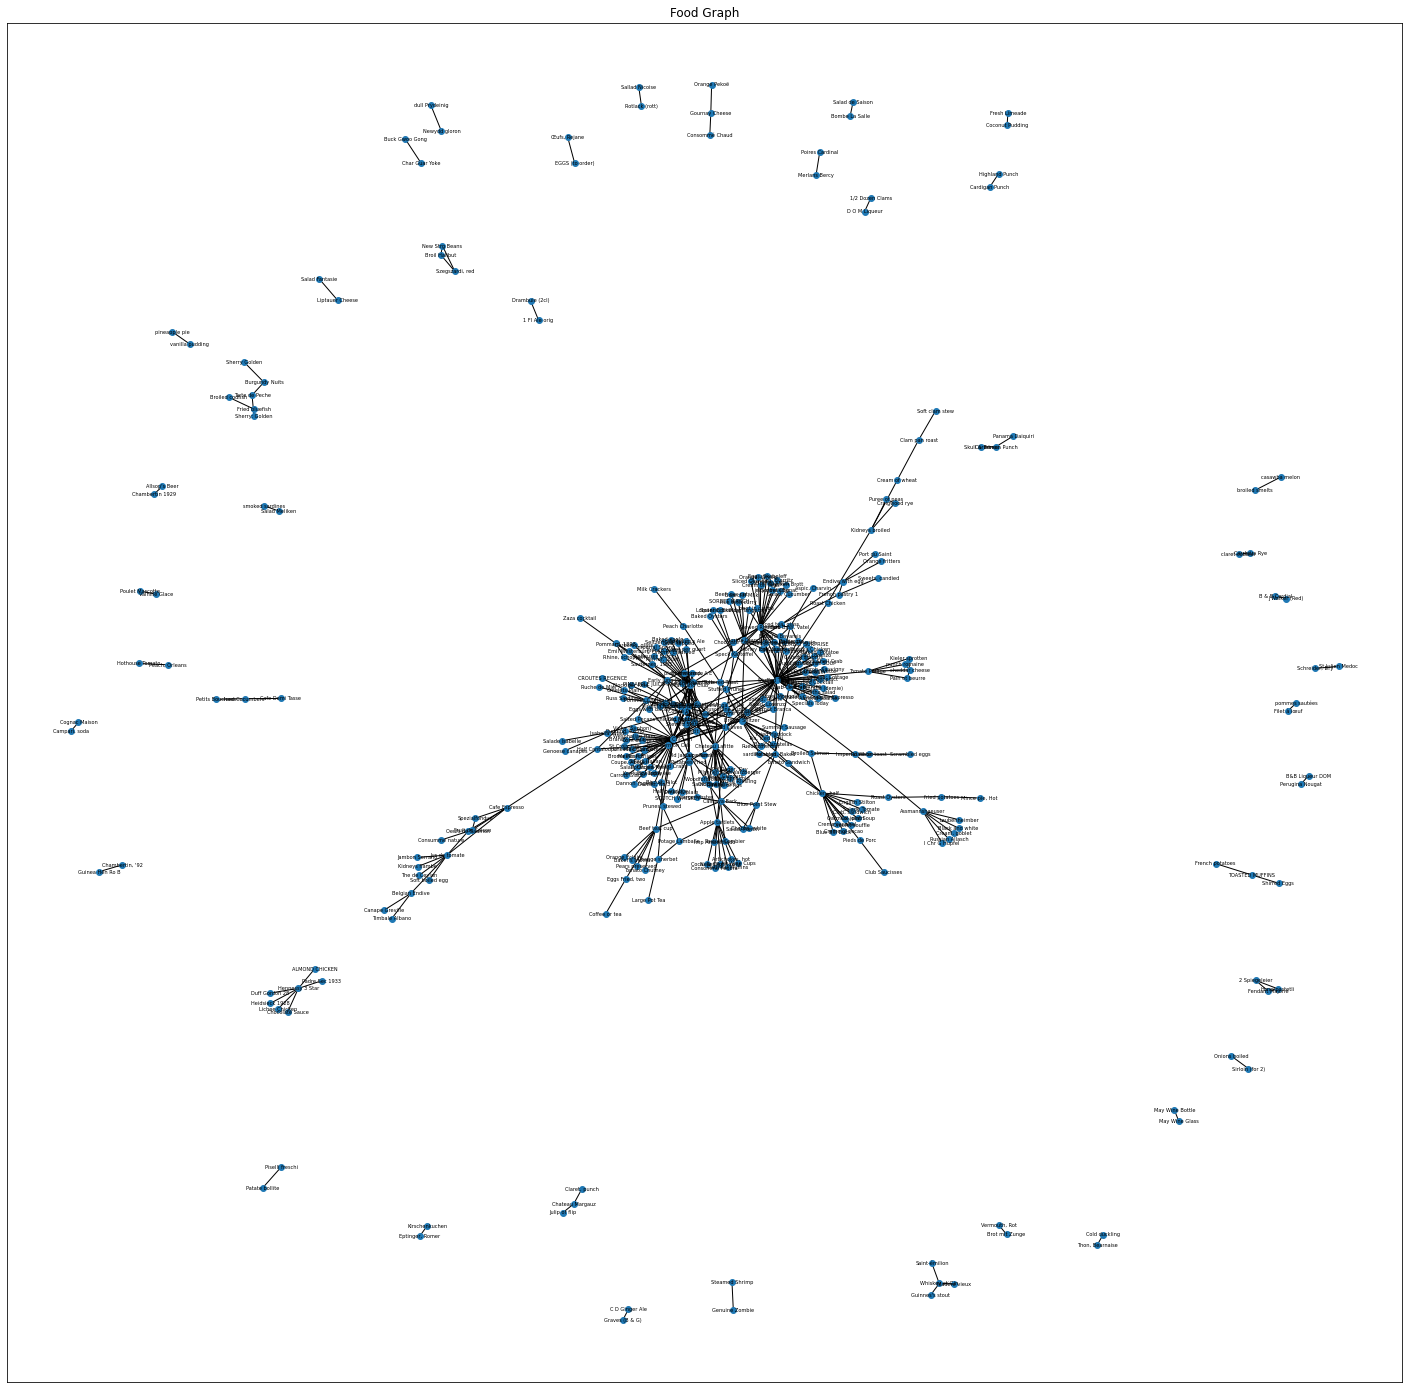

In [143]:
pos = nx.spring_layout(G, scale=.5)
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title("Food Graph")
nx.draw_networkx(G, pos = pos, node_size = 35, font_size = 5) 